# Part 3: Output

This notebook handles the final output generation and visualization:

1. **Geocoding** - Converting from radar coordinates to geographic coordinates
2. **Subset Extraction** - Cropping to final output extent
3. **GeoTIFF Export** - Generating GIS-compatible output files
4. **Visualization** - Displaying the final DPM results

## Input Files
- `score.npy` - Damage score array
- `lat_cropped.rdr`, `lon_cropped.rdr` - Geocoding lookup tables

## Output Files
- `geo_.cor` - Geocoded damage score (ISCE format)
- `final.cor` - Subsetted damage score
- `final.tif` - Final DPM as GeoTIFF

---

# InSAR Score Processing and Geocoding

This script processes the normalized difference score files (`score.npy`) generated in the previous steps, converting them into ISCE2-compatible `.cor` files, performing geocoding, extracting subsets, and saving the results as GeoTIFF files. The workflow involves multiple steps to handle each score file and prepare it for further analysis or visualization.

## Key Features

1. **Loading and Writing ISCE2 Files**:

   * The script loads each `score.npy` file and converts it into an ISCE2-compatible `.cor` file using the `write_isce_file` function from the `mintpy` library.

2. **Geocoding**:

   * After creating the `.cor` file, the script uses the `geocode.py` tool to geocode the interferogram, associating it with corresponding latitude and longitude data.

3. **Subset Extraction**:

   * A geographic subset is extracted from the geocoded interferogram using the `subset.py` tool. The subset is defined by specific latitude and longitude boundaries.

4. **Saving as GeoTIFF**:

   * The subsetted data is saved as a GeoTIFF file using the `save_gdal.py` tool, making the data ready for use in GIS applications.

5. **Error Handling**:

   * The script includes error handling to ensure that if a file cannot be processed, the process continues for the remaining files.

## Workflow Overview

1. **Input Data**:

   * `score.npy`: The normalized difference score files, which are the result of comparing observed and predicted post-earthquake InSAR data.
   * `lat_cropped.rdr` and `lon_cropped.rdr`: The cropped latitude and longitude files for geocoding.

2. **Processing**:

   * For each `score.npy` file:

     * Convert it to ISCE2 `.cor` format.
     * Perform geocoding to associate it with the correct geographic coordinates.
     * Extract a subset of the data based on specified latitude and longitude boundaries.
     * Save the resulting subset as a GeoTIFF file.

3. **Output**:

   * The final output is a set of processed GeoTIFF files, each corresponding to a `score.npy` file.




In [6]:
import numpy as np
import os
import subprocess
from mintpy.utils.writefile import write_isce_file

# Base directory path
base_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"

# Get all _score.npy files
score_files = [f for f in os.listdir(base_dir) 
              if f.endswith("score.npy") and os.path.isfile(os.path.join(base_dir, f))]

# Latitude and longitude file paths (modify to lat_cropped.rdr and lon_cropped.rdr from the parent directory)
lat_file = os.path.join(os.path.dirname(base_dir), "lat_cropped.rdr")
lon_file = os.path.join(os.path.dirname(base_dir), "lon_cropped.rdr")

# Subset extraction parameters
subset_params = "-l 42.625 42.635 -L 13.28 13.30"

# Loop through each score file
for score_file in score_files:
    try:
        # 1. Load npy data
        file_path = os.path.join(base_dir, score_file)
        print(f"Processing file: {score_file}")
        data = np.load(file_path)
        
        # 2. Create output file name base
        base_name = score_file.replace("score.npy", "")
        
        # 3. Write to ISCE format
        cor_file = os.path.join(base_dir, f"{base_name}.cor")
        write_isce_file(
            data=data,
            out_file=cor_file,
            file_type='isce_cor'
        )
        print(f"  ISCE file created: {cor_file}")
        
        # 4. Geocode the file
        geo_cor_file = os.path.join(base_dir, f"geo_{base_name}.cor")
        geocode_cmd = f"geocode.py {cor_file} --lat-file {lat_file} --lon-file {lon_file} --outdir {base_dir}"
        subprocess.run(geocode_cmd, shell=True, check=True)
        print(f"  Geocoding completed: {geo_cor_file}")
        
        # 5. Subset extraction
        subset_cor_file = os.path.join(base_dir, f"{base_name}final.cor")
        subset_cmd = f"subset.py {geo_cor_file} {subset_params} --output {subset_cor_file}"
        subprocess.run(subset_cmd, shell=True, check=True)
        print(f"  Subset extraction completed: {subset_cor_file}")
        
        # 6. Save as GeoTIFF
        tif_file = os.path.join(base_dir, f"{base_name}final.tif")
        gdal_cmd = f"save_gdal.py {subset_cor_file} --output {tif_file}"
        subprocess.run(gdal_cmd, shell=True, check=True)
        print(f"  GeoTIFF generated: {tif_file}")
        
        print(f"File {score_file} processed successfully!\n")
    
    except Exception as e:
        print(f"Error processing file {score_file}: {str(e)}")
        continue

print("All files processed successfully!")


Processing file: score.npy
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.xml
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.vrt
  ISCE file created: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor


number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr
calculate output pixel size using approach 1 (same pixel area before/after resampling)
calculate output pixel size using approach 2 (same matrix shape before/after resampling)
output pixel size in (lat, lon) in degree: (-0.00014761828501290138, 4.800396637925411e-05)
output area extent in (S, N, W, E) in degree: (42.62151966619929, 42.63775767755071, 13.276840049835657, 13.302762191680454)
output file row / column number: (110, 540)
[1/1] preparing geometry for dest_box: (0, 0, 540, 110) --> full src_box: (0, 0, 540, 110)
--------------------------------------------------
resampling file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
--------------------------------------------------1/1
reading band1 in block (0, 0, 540, 110) from .cor ...
nearest resampling with pyres

/home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)


2025-12-03 12:54:43,633 - fiona._env - DEBUG - GDAL_DATA found in environment.
2025-12-03 12:54:43,635 - fiona._env - DEBUG - PROJ_DATA found in environment.
run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce .cor file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor in float32 format
file size in y/x: (110, 540)
num of datasets in file geo_.cor: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 540, 110)
subset coverage in y/x: (0, 0, 540, 110)
data   coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
subset coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
------------------------------------------------------------------------
colormap: gray
figure title: geo_.cor
figure size : [10.0, 5.0]
reading data ...
data    range: [-0.5929633, 0.8276505] 1
display range: [0.0, 1.0] 1
display data in 

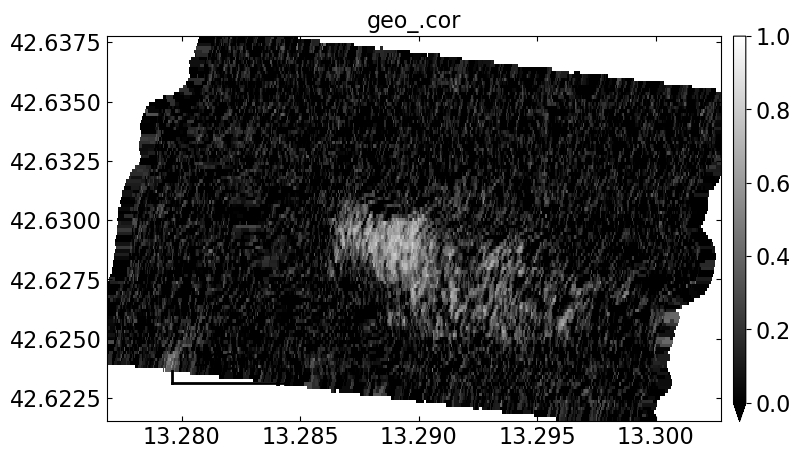

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is gdal .tif file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif in float32 format
file size in y/x: (68, 417)
num of datasets in file final.tif: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 417, 68)
subset coverage in y/x: (0, 0, 417, 68)
data   coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
subset coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
------------------------------------------------------------------------
colormap: jet
figure title: final.tif
figure size : [10.0, 4.0]
reading data ...
data    range: [-0.5929633, 0.8276505] 1
display range: [-0.5929633, 0.8276505] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


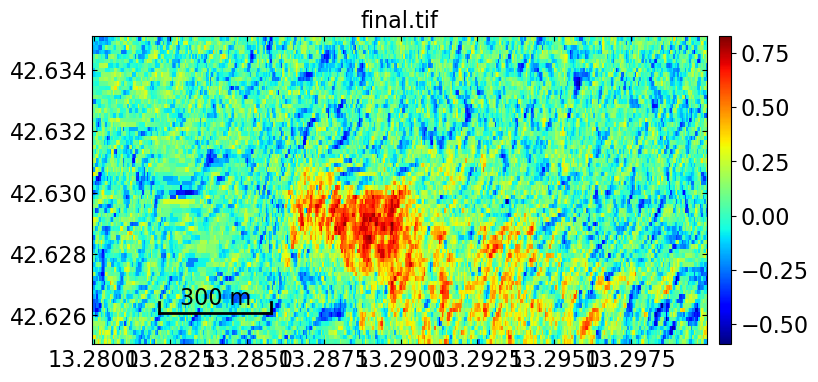

In [7]:
from mintpy.cli import view
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor'.split())
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif'.split())